In [1]:
# class reductionKIblAlgorithm:
#     def __init__(self, n_neighbors=5, p=2):
#         self.n_neighbors = n_neighbors
#         self.p = p # minkowski distance

#         def predict(self, X):
#             """Predict the class labels for the provided data.
#             Parameters
#             ----------
#             X : array-like, shape (n_queries, n_features)
            
#             Returns
#             -------
#             y : array of shape [n_queries] or [n_queries, n_outputs]
#                 Class labels for each data sample.
#             """

#             return y_pred

## W4

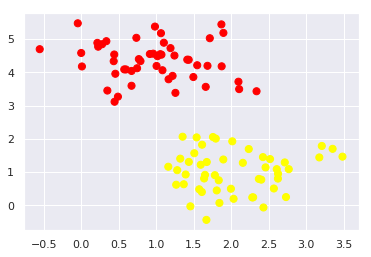

In [7]:
# %matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

import seaborn as sns; sns.set()
from sklearn.datasets.samples_generator import make_blobs

X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

In [9]:
from sklearn.model_selection import train_test_split
# from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

test_size = 0.2
seed = 40


X_train, X_val, y_train, y_val = train_test_split(
                X, y, test_size=test_size, random_state=seed)

# X_train

In [16]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

In [15]:
%%time

from functools import partial
from hyperopt import fmin, hp, tpe, Trials, space_eval
from sklearn.model_selection import (cross_val_score, train_test_split)
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
 
seed_hyper = 1

hyper_space_svm = {
    'kernel':  hp.choice('kernel', ['linear', 'rbf', 'poly', 'sigmoid']),
    
}
# Define search space
# hyper_space_lightgbm = {'n_estimators': 100 + hp.randint('n_estimators', 500),
#                'learning_rate': hp.uniform('learning_rate', 0.01, 0.1),
#                'max_depth':  hp.choice('max_depth', [4, 5, 8, -1]),
#               #  'max_bin': hp.choice('max_bin', [4, 5, 8, 10]),
#                'num_leaves': hp.choice('num_leaves', [15, 31, 63, 127]),
#                'subsample': hp.uniform('subsample', 0.6, 1.0),
#                'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0)}

def evaluate(params, X, y, model='lightgbm'):
    
    # Initilize instance of estimator
#     est = LGBMRegressor(boosting='gbdt', n_jobs=-1, random_state=seed_hyper)
    est = SVC(random_state=seed_hyper)
#     est = svm.SVC(kernel='rbf')
    est.set_params(**params)

    # Calc CV score
    scores = cross_val_score(estimator=est, X=X, y=y, 
                             scoring='accuracy', cv=4)
    score = np.mean(scores)

    return score

# Objective minizmied 
hyperopt_objective_svm = lambda params: (-1.0) * evaluate(params, 
                                                      X_train, 
                                                      y_train)

# Trail
trials = Trials()
 
# Set algoritm parameters
algo = partial(tpe.suggest, 
               n_startup_jobs=20, gamma=0.25, n_EI_candidates=24)
 
# # Fit Tree Parzen Estimator
# best_vals_lightgbm = fmin(hyperopt_objective_lightgbm, space=hyper_space_lightgbm,
#                  algo=algo, max_evals=60, trials=trials,
#                  rstate=np.random.RandomState(seed=seed_hyper))
best_vals_svm = fmin(hyperopt_objective_svm, space=hyper_space_svm,
                 algo=algo, max_evals=60, trials=trials,
                 rstate=np.random.RandomState(seed=seed_hyper))
# Print best parameters
# best_params_lightgbm = space_eval(hyper_space_lightgbm, best_vals_lightgbm)
best_params_svm = space_eval(hyper_space_svm, best_vals_svm)

# Init estimator
# estimator_lightgbm_tuning = LGBMRegressor(boosting='gbdt', n_jobs=-1, random_state=seed_hyper)
estimator_svm_tuning = SVC(random_state=seed_hyper)

# Set params
# estimator_lightgbm_tuning.set_params(**best_params_lightgbm)
estimator_svm_tuning.set_params(**best_params_svm)

# Fit    
# estimator_lightgbm_tuning.fit(X_train, y_train)
estimator_svm_tuning.fit(X_train, y_train)

# y_pred_lightgbm = estimator_lightgbm_tuning.predict(X_val)
y_pred_svm = estimator_svm_tuning.predict(X_val)

# Predict
# score_lightgbm = r2_score(y_val.values, y_pred_lightgbm)
score_svm = accuracy_score(y_val, y_pred_svm)

# print(f'Validation score lightgbm : {score_lightgbm}')
print(f'Best hyperparams: {best_params_svm}')
print(f'Validation score SVM : {score_svm}')

# Train with all training data
# estimator_lightgbm_tuning.fit(X_scaled, y.values)
# estimator_xgboost_tuning.fit(X_scaled, y.values)

100%|██████████| 60/60 [00:00<00:00, 159.36it/s, best loss: -1.0]
Best hyperparams: {'kernel': 'linear'}
Validation score SVM : 1.0
CPU times: user 374 ms, sys: 0 ns, total: 374 ms
Wall time: 386 ms


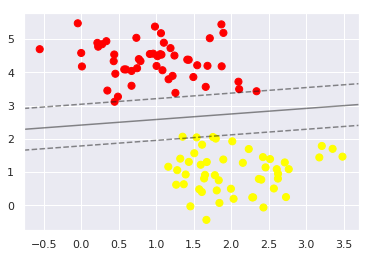

In [18]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(estimator_svm_tuning)

In [20]:
estimator_svm_tuning.support_vectors_

array([[2.33812285, 3.43116792],
       [0.44359863, 3.11530945],
       [1.53853211, 2.04370263],
       [1.35139348, 2.06383637]])

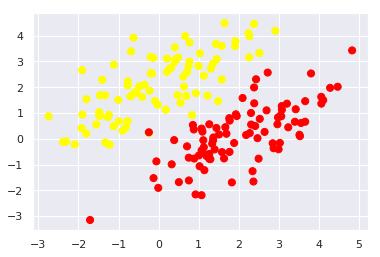

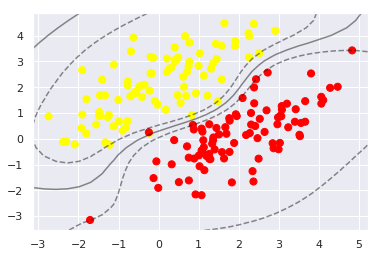

Support vectors : [[-0.24403164  0.2517772 ]
 [ 2.43170075  2.30828468]
 [ 4.82904231  3.42728166]]
Test score SVM : 0.95


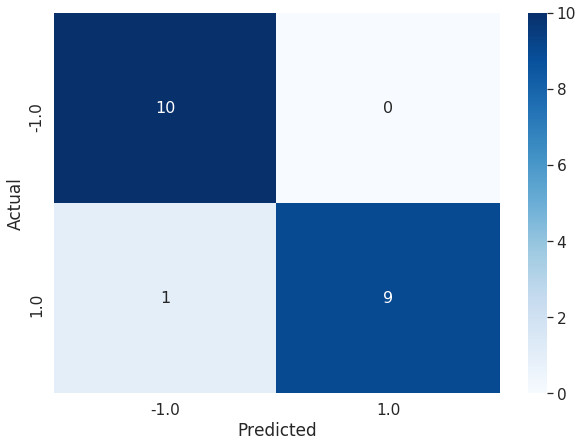

In [58]:
import numpy as np
# import cvxopt
# import cvxopt.solvers
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# if __name__ == "__main__":
import pylab as pl

def generate_data_set1():
    # generate training data in the 2-d case
    mean1 = np.array([0, 2])
    mean2 = np.array([2, 0])
    cov = np.array([[0.8, 0.6], [0.6, 0.8]])
    X1 = np.random.multivariate_normal(mean1, cov, 100)
    y1 = np.ones(len(X1))
    X2 = np.random.multivariate_normal(mean2, cov, 100)
    y2 = np.ones(len(X2)) * -1
    return X1, y1, X2, y2

def generate_data_set2():
    mean1 = [-1, 2]
    mean2 = [1, -1]
    mean3 = [4, -4]
    mean4 = [-4, 4]
    cov = [[1.0,0.8], [0.8, 1.0]]
    X1 = np.random.multivariate_normal(mean1, cov, 50)
    X1 = np.vstack((X1, np.random.multivariate_normal(mean3, cov, 50)))
    y1 = np.ones(len(X1))
    X2 = np.random.multivariate_normal(mean2, cov, 50)
    X2 = np.vstack((X2, np.random.multivariate_normal(mean4, cov, 50)))
    y2 = np.ones(len(X2)) * -1
    return X1, y1, X2, y2

def generate_data_set3():
    # generate training data in the 2-d case
    mean1 = np.array([0, 2])
    mean2 = np.array([2, 0])
    cov = np.array([[1.5, 1.0], [1.0, 1.5]])
    X1 = np.random.multivariate_normal(mean1, cov, 100)
    y1 = np.ones(len(X1))
    X2 = np.random.multivariate_normal(mean2, cov, 100)
    y2 = np.ones(len(X2)) * -1
    return X1, y1, X2, y2

def split_train(X1, y1, X2, y2):
    X1_train = X1[:90]
    y1_train = y1[:90]
    X2_train = X2[:90]
    y2_train = y2[:90]
    X_train = np.vstack((X1_train, X2_train))
    y_train = np.hstack((y1_train, y2_train))
    return X_train, y_train

def split_test(X1, y1, X2, y2):
    X1_test = X1[90:]
    y1_test = y1[90:]
    X2_test = X2[90:]
    y2_test = y2[90:]
    X_test = np.vstack((X1_test, X2_test))
    y_test = np.hstack((y1_test, y2_test))
    return X_test, y_test

def run_svm_dataset1():
    X1, y1, X2, y2 = generate_data_set1()
    X_train, y_train = split_train(X1, y1, X2, y2)
    X_test, y_test = split_test(X1, y1, X2, y2)

     #### 
    # Write here your SVM code and choose a linear kernel
    # plot the graph with the support_vectors_
    # print on the console the number of correct predictions and the total of predictions
    ####


def run_svm_dataset2():
    X1, y1, X2, y2 = generate_data_set2()
    X_train, y_train = split_train(X1, y1, X2, y2)
    X_test, y_test = split_test(X1, y1, X2, y2)

    #### 
    # Write here your SVM code and choose a linear kernel with the best C pparameter
    # plot the graph with the support_vectors_
    # print on the console the number of correct predictions and the total of predictions
    ####



def run_svm_dataset3():
    X1, y1, X2, y2 = generate_data_set3()
    X_train, y_train = split_train(X1, y1, X2, y2)
    X_test, y_test = split_test(X1, y1, X2, y2)

    #### 
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=50, cmap='autumn')
    plt.show()
    
    model = SVC(kernel='rbf', C=50, random_state=42)
    model.fit(X_train, y_train)
    
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=50, cmap='autumn')
    plot_svc_decision_function(model)
    plt.show()
    
    
    y_pred_svm = model.predict(X_test)
    score_svm = accuracy_score(y_test, y_pred_svm)

#     print(set(y_pred_svm))
#     print(len(y_test))

    # print(f'Validation score lightgbm : {score_lightgbm}')
#     print(f'Best hyperparams: {best_params_svm}')
    print(f'Support vectors : {model.support_vectors_[:3]}')
    print(f'Test score SVM : {score_svm}')
    # Write here your SVM code and use a gaussian kernel 
    # plot the graph with the support_vectors_
    # print on the console the number of correct predictions and the total of predictions
    ####
    
    data = confusion_matrix(y_test, y_pred_svm)
    df_cm = pd.DataFrame(data, columns=np.unique(y_pred_svm), index = np.unique(y_pred_svm))
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    plt.figure(figsize = (10,7))
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size
#############################################################
#############################################################
#############################################################

# EXECUTE SVM with THIS DATASETS      


#############################################################
#############################################################
#############################################################
run_svm_dataset3()   # data distribution 3

In [54]:
import sklearn

sklearn.__version__

'0.22'

In [26]:
# X_train, y_train = split_train(*generate_data_set3())
# X_train, y_train = split_train(*generate_data_set3())

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

In [ ]:
# run_svm_dataset1()   # data distribution 1
# run_svm_dataset2()   # data distribution 2
